In [1]:
import fsspec
import proplot
import xarray as xr

import plotting

In [2]:
plotting.configure_style()

In [3]:
def open_data(variable, validation_year):
    bias = xr.open_dataset("annual_mean_bias.nc")[[VARIABLE]].sel(validation_year=validation_year)
    metrics = xr.open_dataset("annual_mean_metrics.nc")[[VARIABLE]].sel(validation_year=validation_year)
    stack_dims = ("configuration", "time")
    return bias.stack(sample=stack_dims), metrics.stack(sample=stack_dims)

In [4]:
VALIDATION_YEAR = "Year two"
VARIABLE = "air_temperature"
PALETTE = [
    "#E69F00",
    "#009E73",
    "#56B4E9",
]
CLIMATES = ["Minus 4 K", "Unperturbed", "Plus 4 K", "Plus 8 K"]

bias, metrics = open_data(VARIABLE, VALIDATION_YEAR)

In [5]:
ML_CORRECTED_SAMPLES = bias.configuration == "ML-corrected seed 2"
BASELINE_SAMPLES = bias.configuration == "Baseline"
NUDGED_SAMPLES = (bias.configuration == "Nudged") & (bias.time.dt.year == 2018)
SAMPLES = ML_CORRECTED_SAMPLES | BASELINE_SAMPLES | NUDGED_SAMPLES

In [6]:
ml_corrected_bias = bias.isel(sample=ML_CORRECTED_SAMPLES).mean("sample")
baseline_bias = bias.isel(sample=BASELINE_SAMPLES).mean("sample")
nudged_bias = bias.isel(sample=NUDGED_SAMPLES).mean("sample")

In [7]:
zonal_rmse = plotting.to_plottable_dataframe(metrics, VARIABLE, "Below tapering region", "rmse", SAMPLES, "zonal_region")
zonal_mean = plotting.to_plottable_dataframe(metrics, VARIABLE, "Below tapering region", "mean", SAMPLES, "zonal_region")

/home/spencerc/miniconda3/envs/fv3net-makefile/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


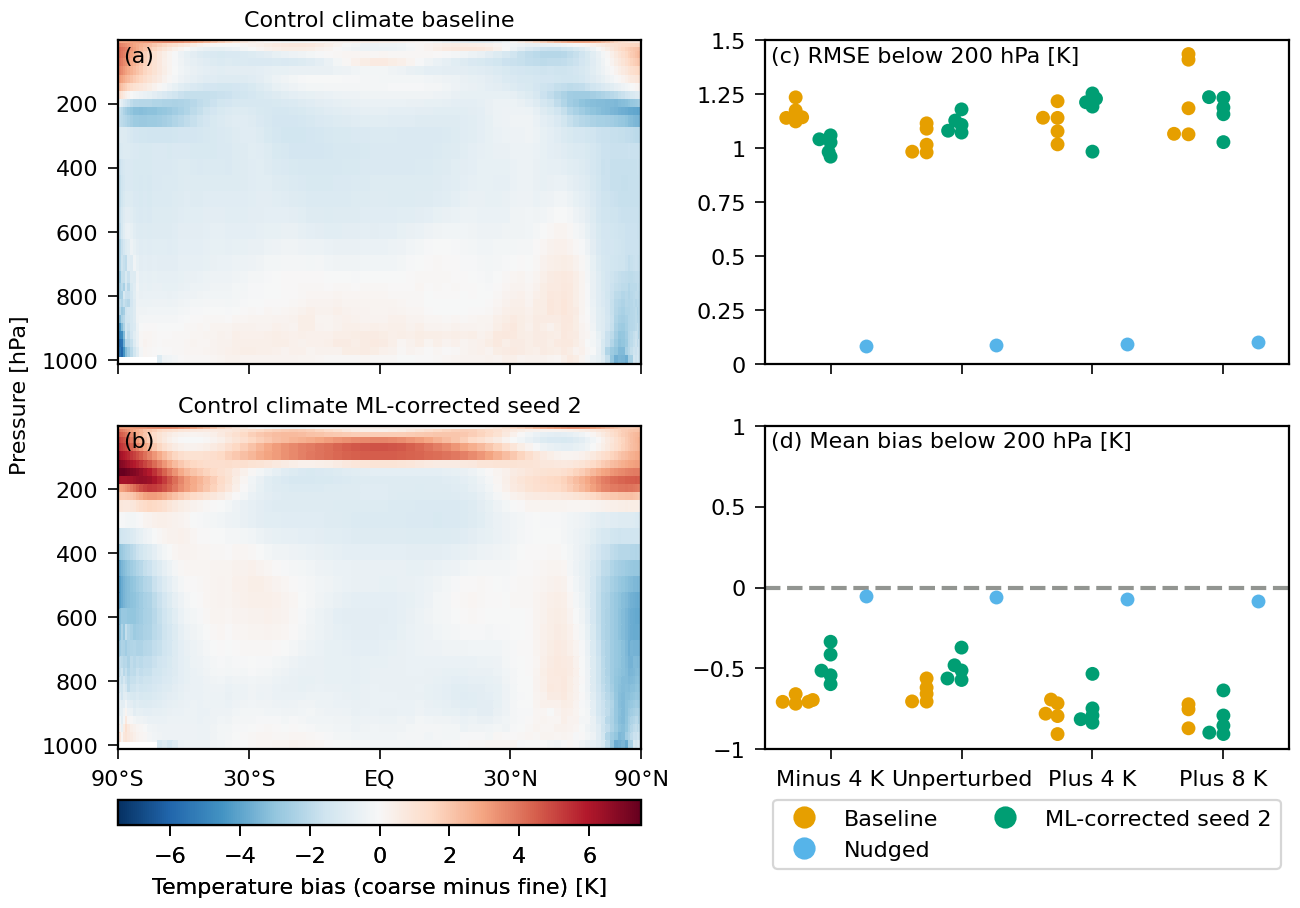

In [8]:
array = [
    [1, 2],
    [3, 4]
]
fig, axes = proplot.subplots(
    array,
    figwidth=6.5,
    refaspect=1/0.618,
    sharey="labels"
)

ax1, ax2, ax3, ax4 = axes

p = (
    bias
    .air_temperature
    .sel(configuration="Baseline", climate="Unperturbed")
    .mean("time")
    .plot(
        ax=ax1,
        cmap="RdBu_r",
        vmin=-7.5,
        vmax=7.5,
        add_colorbar=False,
        x="sinlat",
        yincrease=False,
        discrete=False
    )
)

p = (
    bias
    .air_temperature
    .sel(configuration="ML-corrected seed 2", climate="Unperturbed")
    .mean("time")
    .plot(
        ax=ax3,
        cmap="RdBu_r",
        vmin=-7.5,
        vmax=7.5,
        add_colorbar=False,
        x="sinlat",
        yincrease=False,
        discrete=False
    )
)

plotting.swarmplot_by_category(
    ax2, 
    zonal_rmse, 
    "air_temperature",
    PALETTE,
    add_legend=False,
    dodge=True,
    x="climate",
    order=CLIMATES,
)

ax2.set_ylim(0, 1.5)
ax2.set_ylabel("")
ax2.set_xlabel("")

plotting.swarmplot_by_category(
    ax4, 
    zonal_mean, 
    "air_temperature",
    PALETTE,
    add_legend=True,
    dodge=True,
    x="climate",
    order=CLIMATES,
    legend_kwargs={"loc": "bottom", "ncol": 2}
)

ax4.set_ylim(-1, 1)
ax4.set_xlabel("")
ax4.set_ylabel("")
ax4.axhline(0.0, color="gray", ls="--")

ax3.colorbar(p, loc="bottom", label="Temperature bias (coarse minus fine) [K]", width=0.125)

for ax in [ax1, ax3]:
    ax.set_xlabel("")
    ax.set_ylabel("Pressure [hPa]")
    ax.set_xlim(-1, 1)
    ax.set_xticks([-1, -0.5, 0, 0.5, 1])
    ax.set_xticklabels([u"90°S", u"30°S", u"EQ", u"30°N", u"90°N"])
    
ax1.set_title("Control climate baseline")
ax3.set_title("Control climate ML-corrected seed 2")

ax1.annotate("(a)", xy=(0, 1), xytext=(2, -2), va='top', xycoords='axes fraction', textcoords='offset points')
ax3.annotate("(b)", xy=(0, 1), xytext=(2, -2), va='top', xycoords='axes fraction', textcoords='offset points')
ax2.annotate("(c) RMSE below 200 hPa [K]", xy=(0, 1), xytext=(2, -2), va='top', xycoords='axes fraction', textcoords='offset points')
ax4.annotate("(d) Mean bias below 200 hPa [K]", xy=(0, 1), xytext=(2, -2), va='top', xycoords='axes fraction', textcoords='offset points')

fig.savefig("figure-12.png", dpi=200)
fig.savefig("figure-12.pdf")